# Image Processing in Python

## Introduction

Yesterday, we gave a brief overview of Python and three powerful libraries we will be using to develop for DeepCell. Today, we will become more familiar with SciPy and in particular the `scikit-image` library as we review the basics of image processing using Python. <i> NB: scikit-image has a description of tag `skimage` that can be used interchageably with the offical name.</i>

In this tutorial, we will cover:

* Loading & Handling Image Data: Input/output, Data Types, and Colorspaces
* Preprocessing: Filtering, Background Subtraction, and Contrast Adjustment
* Foreground Detection: Thresholding and Morphological Operations
* Object Detection and Segmentation: Labeling, Seeding and Expansion
* Postprocessing: Affine Transformations
* Writing Output to Files: Images, JSON, and NPZ

## Loading and Handling Image Data

`skimage` has a number of useful functions we can import to load and manipulate images, as well as save the resulting images. Remember, though, this library builds on NumPy, so we will need to import that library as well.

In [6]:
import numpy as np

from skimage.io import imread, imsave
from skimage.transform import resize as imresize

# Read an JPEG image into a numpy array
#img = imread('resources/img_000000000_Phase_000.png')
img = imread('resources/cat.jpg')
print(img.dtype, img.shape)  # Prints "uint8 (400, 248, 3)"

# We can tint the image by scaling each of the color channels
# by a different scalar constant. The image has shape (400, 248, 3);
# we multiply it by the array [1, 0.95, 0.9] of shape (3,);
# numpy broadcasting means that this leaves the red channel unchanged,
# and multiplies the green and blue channels by 0.95 and 0.9
# respectively.
img_tinted = img * [1, 0.95, 0.9]

# Resize the tinted image to be 300 by 300 pixels.
img_tinted = imresize(img_tinted, (300, 300))

# Write the tinted image back to disk
imsave('resources/cat_tinted.jpg', np.uint8(img_tinted))


uint8 (400, 248, 3)


/home/emoen/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Rather than "hardcoding" the file path, a more robust way of handling these operations is to designate a section of code to specify the directory path and file name as variables. 

If the file is not in the current working directory, you must also have a way of specifying the path to the directory where the file is stored. In our case, the example images are stored in the directory called 'resources' in the same folder as this notebook. Note that you can use either the full path - something like r"/home/user/bootcamp/intro-to-deepcell/resources/example_cells_1.tif" or the relative path, starting from the current working directory.

NB: Paths and filenames can contain slashes, empty spaces and other special symbols, which can cause trouble for programming languages under certain circumstances. To circumvent such trouble, add the letter r before your string definition to create a so-called 'raw string', which is not affected by these problems (e.g. `my_raw_string = r"some string with funny symbols: \\\!/~***!"`).

In [7]:
# Create a string variable with the name of the file you'd like to load (here: 'example_cells_1.tif').
# Suggested name for the variable: filename
filename = r'img_000000000_FITC_001.png'

# Create a string variable with the path to the directory that contains the file you'd like to load.
# Suggested name for the variable: dirpath
dirpath = r'resources'  # Relative path
#dirpath = r'/home/user/bootcamp/intro-to-deepcell/resources/img_000000000_FITC_001.png'  # Absolute path 

In [8]:
# Now combine the directory path and file name into one variable, the file path

# Import the function 'join' from the module 'os.path'
# This function automatically takes care of the slashes that need to be added when combining two paths.
from os.path import join

# Print the result to see that everything is correct
# Suggested name for the variable: filepath
filepath = join(dirpath, filename)
print(filepath)

resources/img_000000000_FITC_001.png


With the file path established, we can load the image (using the `imread` function we imported earlier), make sure the load was successful, and display the image.

In [9]:
# Load 'img_000000000_Far-red_001.png' and store it in a variable.
# Suggested name for the variable: img
img = imread(filepath)

In [10]:
# Check that the load went as expected

# Check that 'img' is a variable of type 'ndarray' - use Python's built-in function 'type'.
print("Loaded array is of type:", type(img))

# Print the shape of the array using the numpy-function 'shape'. 
print("Loaded array has shape:", img.shape)

# Check the datatype of the individual numbers in the array. You can use the array attribute 'dtype' to do so.
print("Loaded values are of type:", img.dtype)

Loaded array is of type: <class 'numpy.ndarray'>
Loaded array has shape: (1080, 1280)
Loaded values are of type: uint16


NB: The dtype should be 'uint16', because these are unsigned 16-bit integer images. Another common dtype for images is uint8. You can read more about the differences [here](https://www.mathworks.com/help/matlab/creating_plots/working-with-8-bit-and-16-bit-images.html) and [here](https://printaura.com/8-bit-vs-16-bit-images-whats-the-difference-which-to-use/)

Now we're ready to take a look at images. To plot the array as an image, use pyplot's functions `plt.imshow` followed by `plt.show`. 

You can check the documentation for `plt.imshow` and note the parameters that can be specified, such as colormap (cmap)
and interpolation. Since we are working with scientific data, interpolation is unwelcome, so you should set it to "none". The most common cmap for grayscale images is naturally "gray". You may also want to adjust the size of the figure. You can do this by preparing the figure canvas with the function `plt.figure` before calling `plt.imshow`. The canvas size is adjusted using the keyword argument 'figsize' when calling `plt.figure`.

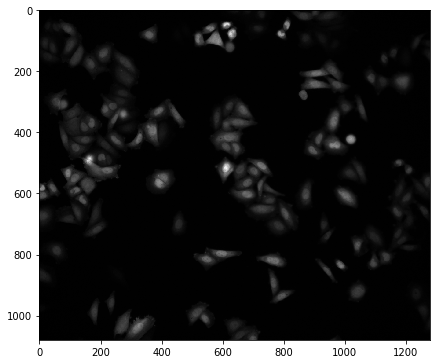

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.imshow(img, interpolation='none', cmap='gray')
plt.show()

Don't worry if it's dark, we'll fix that in a minute. In the meantime, for our peace of mind, here is a side-by-sdie example using our cat image from ealier:

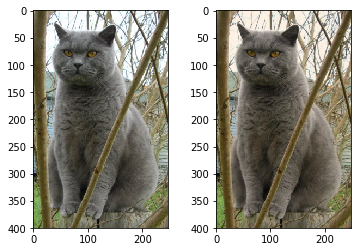

In [213]:
img2 = imread('resources/cat.jpg')
img_tinted2 = img2 * [1, 0.95, 0.9]

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(img2)

# Show the tinted image
plt.subplot(1, 2, 2)

# A slight gotcha with imshow is that it might give strange results if presented with data that is not uint8. 
# To work around this, we explicitly cast the image to uint8 before displaying it.
plt.imshow(np.uint8(img_tinted2))
plt.show()

## Preprocessing

### Filtering

Let's start simple with an application of Gaussian smoothing. To do so, we will use the Gaussian filter function `ndi.filters.gaussian_filter` from the image processing module `scipy.ndimage`. Make sure and review the SciPy documentation to see how to use this function. 

In [15]:
# Import
from skimage.filters.thresholding import threshold_otsu

# Import the image processing package scipy.ndimage as ndi
import scipy.ndimage as ndi

# The documentation tells us that the gaussian_filter function expects a smoothing factor sigma, 
# so we will arbitrarily define one (this can be changed later)
sigma = 4

# Apply the filter and allocate the output to a new variable.
img_smooth = ndi.filters.gaussian_filter(img, sigma)

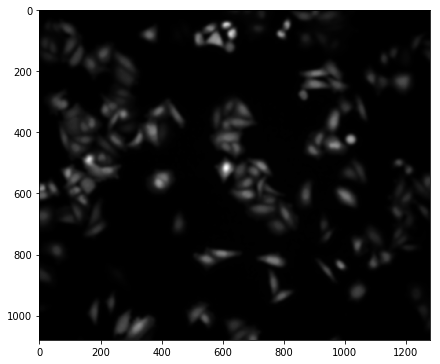

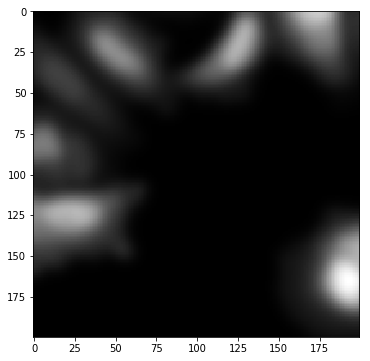

In [17]:
# Visualize the result using 'plt.imshow'

# Compare with the original image visualized above. Can you optimize sigma such that the image looks 
# smooth without blurring the membranes too much?
plt.figure(figsize=(7,7))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.show()

# To have a closer look at a specific region of the image, crop that region out and show it in a 
# separate plot. Remember that you can crop arrays by "indexing" or "slicing" them similar to lists.
plt.figure(figsize=(6,6))
plt.imshow(img_smooth[400:600, 200:400], interpolation='none', cmap='gray')
plt.show()

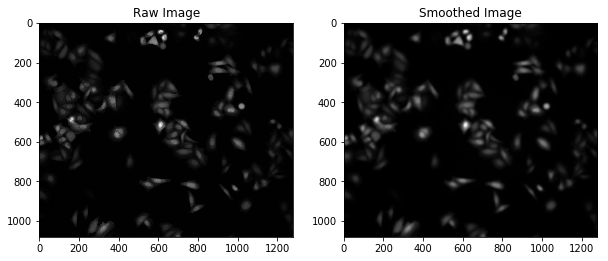

In [18]:
# Look at the raw and smoothed images side by side using 'plt.subplots'
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img, interpolation='none', cmap='gray')
ax[1].imshow(img_smooth, interpolation='none', cmap='gray')
ax[0].set_title('Raw Image')
ax[1].set_title('Smoothed Image')
plt.show()

### Contrast Adjustment

Dylan Discussion Here

In [214]:
#Dylan Code Here


### Edge Detection

Dylan Discussion Here

In [214]:
#Dylan Code Here


## Foreground Detection

### Manual Thresholding & Threshold Detection

In [215]:
# Create a variable (int) to hold a threshold value, which can be changed later to something more suitable.
thresh = 200

# Recall that relational (Boolean) expressions, such as 'smaller' (<), 'equal' (==) or 'greater or equal' (>=),
# can be used with numpy arrays to directly assign the result to a new variable.
mem = img > thresh

# Check the dtype of your thresholded image - it should be boolean, meaning an array filled with 'True' and 'False',
# where 'True' is the foreground (regions above the threshold) and 'False' is the background.
print(mem.dtype)

bool


Let's take a look at the result. 

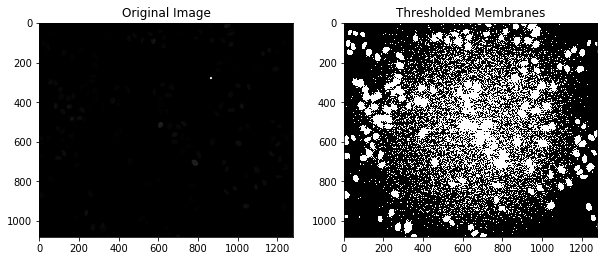

In [216]:
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img, interpolation='none', cmap='gray')
ax[1].imshow(mem, interpolation='none', cmap='gray')
ax[0].set_title('Original Image')
ax[1].set_title('Thresholded Membranes')
plt.show()

Now, we can iterate through various threshold values to select something more appropriate. To do so interactively, we will utilize a class of interactive functions called 'widgets.' These are incredibly useful in exploratory data analysis to create simplified 'User Interfaces' (UIs) on the fly.

In [217]:
# Prepare widget
from ipywidgets import interact
@interact(thresh=(100,700,20))
def select_threshold(thresh=200):
    
    # Thresholding
    mem = img > thresh
    
    # Visualization
    plt.figure(figsize=(7,7))
    plt.imshow(mem, interpolation='none', cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=200, description='thresh', max=700, min=100, step=20), Output()), _dom_c…

Let's say we get tired of searching for the perfect threshold by hand (regardless of how cool our widget is). The scikit-image module `skimage.filters.thresholding` provides several threshold detection algorithms. One of the most popular ones 
is [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method). We can import the module and use it to automatically 
determine a threshold for the smoothed image. Then we can apply the threshold and visualize the result.

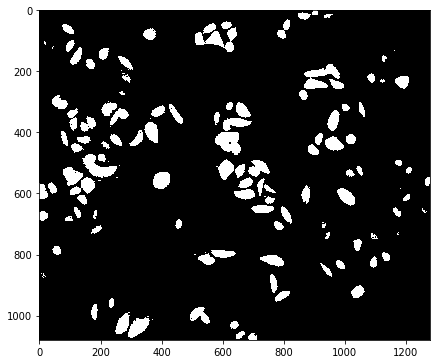

In [12]:
# Import
from skimage.filters.thresholding import threshold_otsu

# Calculate and apply threshold
thresh = threshold_otsu(img)
mem = img > thresh
    
# Visualization
plt.figure(figsize=(7,7))
plt.imshow(mem, interpolation='none', cmap='gray')
plt.show()

This example highlights a few important points: (1) Python (and the packages available for it) are very powerful in their ability to solve difficult problems quickly in very few lines of code; and (2) this can be dangerous - with great power comes great responsibility -> it is up to you to find these modules and understand what sort of data they are expecting.   

## Morphological Operations

### Structuring Elements and Adaptive Thresholding

In our earlier section on thresholding, we quickly discovered the limitations of naive thresholding by a fixed value accross an entire image. Adaptive thresholding methods improve on this approach by varying the threshold for certain parts of the image.  

One way of accomplishing this is known as adpative background subtraction. In this approach, we use a strong "mean filter" with a circular [structuring element](https://en.wikipedia.org/wiki/Structuring_element) to create the background image. Then, we use this background image for thresholding. 

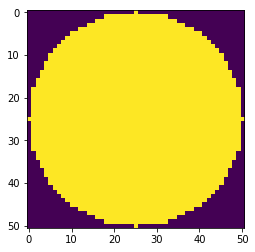

In [232]:
# Create a circular structuring element (SE) whose size depends on i
i = 51
SE = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# Visualize the result
plt.imshow(SE, interpolation='none')
plt.show()

In [233]:
# Create the background by running a mean filter over the image using the disc SE and assign the output to a new variable
# Use the function 'skimage.filters.rank.mean'
from skimage.filters import rank 
#bg = rank.mean(~np.uint8(img_smooth), selem=SE)
bg = rank.mean(img_smooth, selem=SE)

/home/emoen/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 14 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


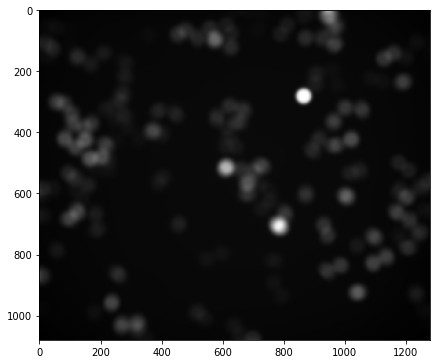

In [234]:
# Visualize the resulting background image. 
plt.figure(figsize=(7,7))
plt.imshow(bg, interpolation='none', cmap='gray')
plt.show()

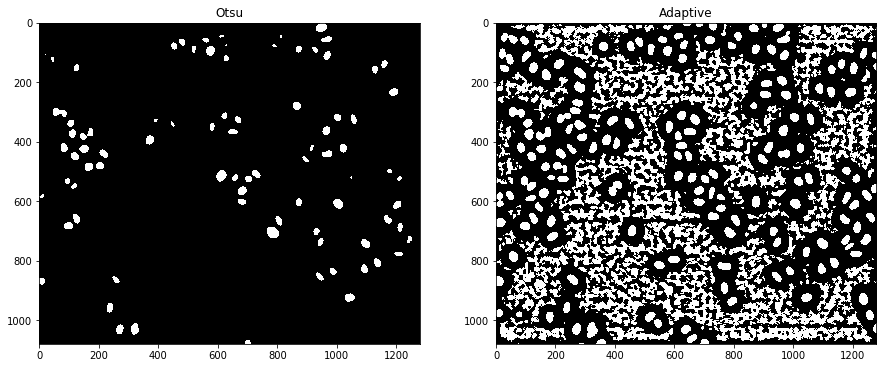

In [235]:
# Threshold the Gaussian-smoothed original image against the background image using a relational expression
mem = img_smooth > bg

# Visualize the result against Otsu
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(Otsu, interpolation='none', cmap='gray')
ax[1].imshow(mem, interpolation='none', cmap='gray')
ax[0].set_title('Otsu')
ax[1].set_title('Adaptive')
plt.show()

### Improving Masks with Binary Morphology

While it is an improvment on our original results, our latest segmentation still leaves something to be desired. Let's see if we can improve the membrane segmentation with morphological operations. 

There are a number of operations available in the `ndimage` module that may be of use here (`ndi.binary_closing` or `ndi.binary_fill_holes` for example). Feel free to explore and see how the different functions affect the mask. Can you optimize the mask, for example by closing gaps?

Also, note that the default SE for these functions is a square. Try to create another disc-shaped SE and see how that changes the outcome.

In our first attempt, we are going to attempt to get rid of these speckles using binary hole filling. The documentation makes it clear that, for `ndi.binary_fill_holes` to work as intended, we need to invert the mask. The function `np.logical_not` or the corresponding operator '~' will help us here.

In [204]:
#mem_holefilled = np.logical_not(ndi.binary_fill_holes(np.logical_not(mem)))  # Long form
mem_holefilled = ndi.binary_fill_holes(mem)  # Short form

In [205]:
# New circular SE of appropriate size 
i = 17
SE = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# Sometimes, SE can introduce boundary artifact issues that can be solved with 'padding.' 'Padding' refers to the 
# extension of the image at the boundaries, in this case using a 'reflection' of the pixel values next to the boundary. 
# If morphological operations are done on the padded image, the boundary artifacts will occur in the padded region
# outside the original image, which can simply be cropped out again at the end.
pad_size = i+1
mem_padded = np.pad(mem_holefilled, pad_size, mode='reflect')

# Binary closing works well to round off the membranes and close gaps
mem_final = ndi.binary_closing(mem_padded, structure=SE)

# This slicing operation crops the padded image back to the original size
mem_final = mem_final[pad_size:-pad_size, pad_size:-pad_size]

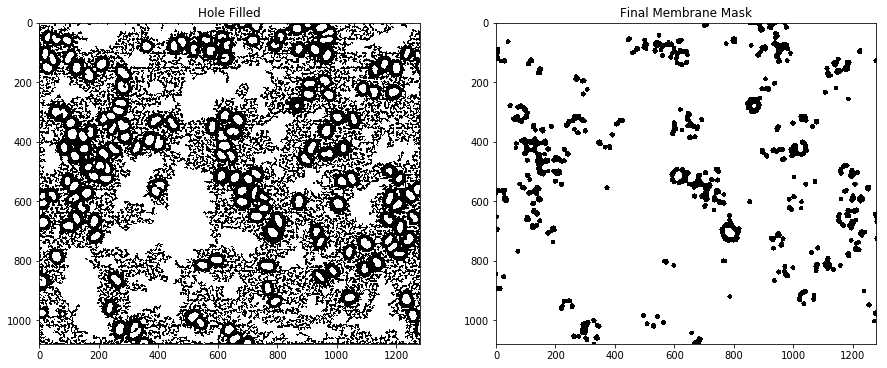

In [206]:
# Visualize the final result
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(mem_holefilled, interpolation='none', cmap='gray')
ax[1].imshow(mem_final, interpolation='none', cmap='gray')
ax[0].set_title('Hole Filled')
ax[1].set_title('Final Membrane Mask')
plt.show()

### The Watershed Transform

## Postprocessing

### Affine Transformations

## Writing Output to Files

### Images

### NPZ

### JSON